In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
import pandas as pd
import geopandas as gpd
from src.settings import *
from tqdm.auto import tqdm
# import torch
# import pytorch_lightning as pl
# from torch.utils.data.dataloader import DataLoader
# from torch.utils.data.dataset import Dataset
# from pytorch_lightning.loggers import WandbLogger
# import wandb
# from src.models.autoencoder import LitAutoEncoder, LitVAE
import json5 as json
import pickle as pkl
from src.tools.configs import ExperimentConfig, DatasetGenerationConfig
from src.tools.feature_extraction import SpatialDataset
import dataclasses
import gzip
from src.tools.feature_extraction import apply_feature_selection, normalize_df, apply_features_mapping
import xgboost as xgb
from IPython.display import display
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import gzip

tqdm.pandas()

In [61]:
ec = ExperimentConfig(
    dataset_filename="dataset_2021-11-29_20-45-47_poland.pkl.gz",
    # dataset_filename="dataset_2021-12-11_21-19-43_all.pkl.gz",
    model_name="autoencoder",
    mode="edges",
    test_cities=["Łódź"],
    random_seed=42,
    batch_size=64,
    num_workers=3,
    shuffle=True,
    hidden_dim=64,
    enc_out_dim=40,
    latent_dim=30,
    epochs=10,
    kl_coeff=0.1,
    lr=1e-3
)

In [62]:
ds_path = FEATURES_DIR / ec.dataset_filename
with gzip.open(ds_path, "rb") as f:
    ds: SpatialDataset = pkl.load(f)

ds.__annotations__

{'config': src.tools.configs.DatasetGenerationConfig,
 'cities': pandas.core.frame.DataFrame,
 'edges': geopandas.geodataframe.GeoDataFrame,
 'hexagons': geopandas.geodataframe.GeoDataFrame,
 'hex_agg': typing.Optional[pandas.core.frame.DataFrame],
 'hex_agg_normalized': typing.Optional[pandas.core.frame.DataFrame]}

In [63]:
ds_config = ds.config
cities = ds.cities
edges = ds.edges
hexagons = ds.hexagons
hex_agg = ds.hex_agg
hex_agg_normalized = ds.hex_agg_normalized

In [64]:
random_seed = ec.random_seed

In [65]:
data = apply_feature_selection(edges, ds_config.featureset_selection)
data = apply_features_mapping(data, [{
    "feature": "highway",
    "mapping": {
        "motorway_link": "motorway",
        "primary_link": "primary",
        "secondary_link": "secondary",
        "tertiary_link": "tertiary",
        "trunk_link": "trunk"
    }
}])
# data = apply_features_mapping(data, [{
#     "feature": "highway",
#     "mapping": {
#         'secondary': 'not_residential', 
#         'tertiary': 'not_residential', 
#         'living_street': 'not_residential', 
#         'primary': 'not_residential', 
#         'unclassified': 'not_residential', 
#         'motorway': 'not_residential', 
#         'trunk': 'not_residential'
#     }
# }])
# data = data.drop(columns="highway_residential")
data

oneway_True  lanes_1  lanes_2  \
continent country city      h3_id                                            
Europe    Poland  Białystok 891f5106993ffff            1        0        0   
                            891f5106993ffff            1        0        1   
                            891f5106d67ffff            1        0        1   
                            891f5106997ffff            1        0        0   
                            891f5106993ffff            1        0        0   
...                                                  ...      ...      ...   
                  Łódź      891e2186aafffff            0        0        0   
                            891e2186a33ffff            0        0        0   
                            891e2186a33ffff            0        0        0   
                            891e2186a33ffff            0        0        0   
                            891e2186aafffff            0        0        0   

                                             lanes_3  lanes_4  lanes_5  \
continent country city      h3_id                                        
Europe    Poland  Białystok 891f5106993ffff        0        0        1   
                            891f5106993ffff        0        1        0   
                            891f5106d67ffff        0        1        0   
                            891f5106997ffff        0        1        0   
                            891f5106993ffff        0        1        0   
...                                              ...      ...      ...   
                  Łódź      891e2186aafffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186aafffff        0        0        0   

                                             lanes_6  lanes_7  lanes_8  \
continent country city      h3_id                                        
Europe    Poland  Białystok 891f5106993ffff        0        0        0   
                            891f5106993ffff        0        0        0   
                            891f5106d67ffff        0        0        0   
                            891f5106997ffff        0        0        0   
                            891f5106993ffff        0        0        0   
...                                              ...      ...      ...   
                  Łódź      891e2186aafffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186a33ffff        0        0        0   
                            891e2186aafffff        0        0        0   

                                             lanes_9  ...  width_13.0  \
continent country city      h3_id                     ...               
Europe    Poland  Białystok 891f5106993ffff        0  ...           0   
                            891f5106993ffff        0  ...           0   
                            891f5106d67ffff        0  ...           0   
                            891f5106997ffff        0  ...           0   
                            891f5106993ffff        0  ...           0   
...                                              ...  ...         ...   
                  Łódź      891e2186aafffff        0  ...           0   
                            891e2186a33ffff        0  ...           0   
                            891e2186a33ffff        0  ...           0   
                            891e2186a33ffff        0  ...           0   
                            891e2186aafffff        0  ...           0   

                                             width_14.0  width_15.0  \
continent country city      h3_id                                     
Europe    Po

In [66]:
data["oneway_False"] = 1 - data["oneway_True"]

In [67]:
features = list(ds_config.featureset_selection["features"].keys())
for feature in tqdm(features):
    wide_feature_cols = [col for col in data.columns if feature in col]
    data[feature] = data[wide_feature_cols].idxmax(axis=1).astype("category")
    data[feature][data[wide_feature_cols].sum(axis=1) == 0] = None
    data.drop(columns=wide_feature_cols, inplace=True)

100%|██████████| 9/9 [00:01<00:00,  6.06it/s]


In [68]:
# data = pd.concat([
#     data[data["highway"] == "highway_residential"].sample(frac=0.25, random_state=random_seed, replace=False), 
#     data[data["highway"] != "highway_residential"]]
#     )

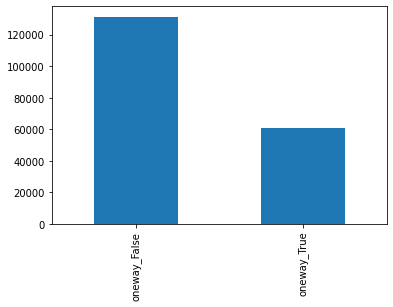

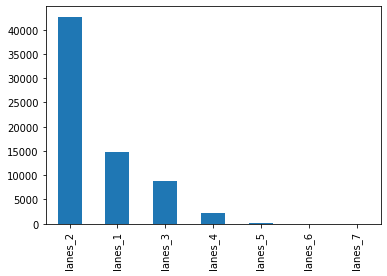

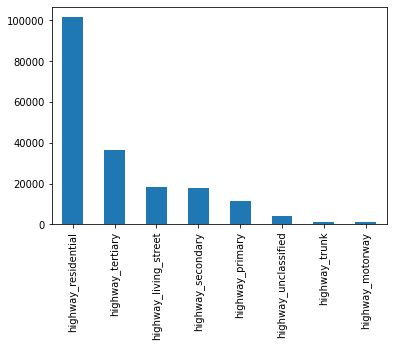

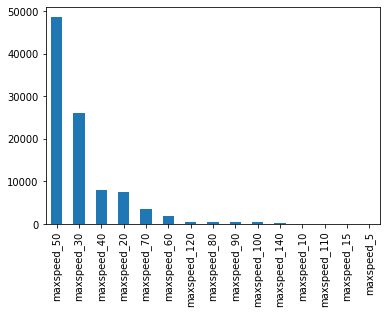

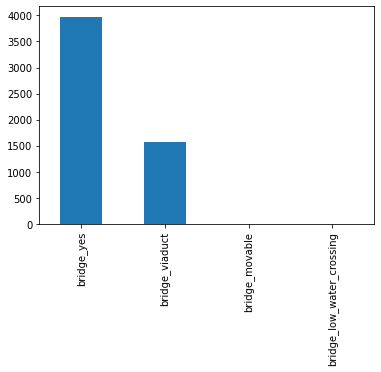

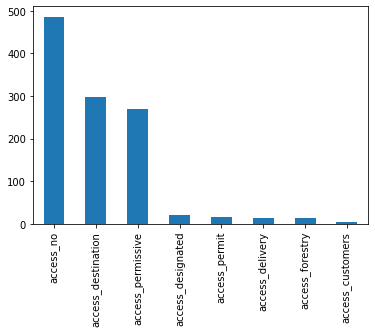

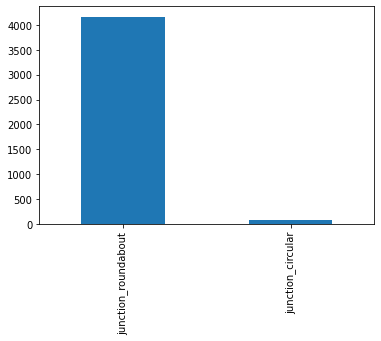

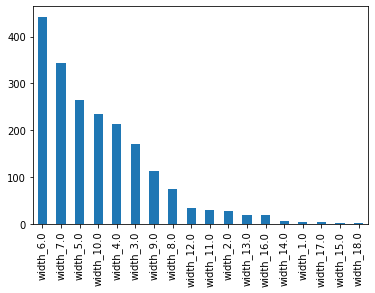

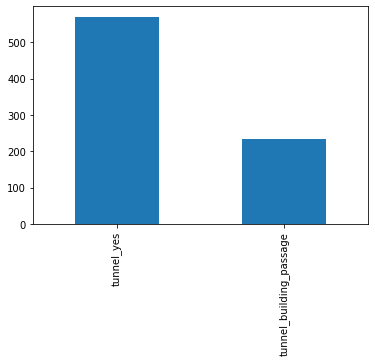

In [69]:
for f in features:
    data[f].value_counts().plot(kind="bar")
    plt.show()

<AxesSubplot:>

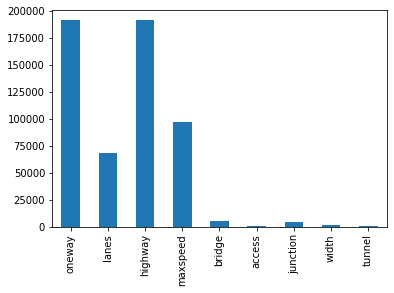

In [70]:
data.notna().sum().plot(kind="bar")

In [71]:
features_numeric = ["lanes", "maxspeed", "width"]

for feature in features_numeric:
    data[feature] = data[feature].apply(lambda x: float(x.split("_")[1]) if x is not None else None).astype(float)

In [72]:
# data = data[["oneway", "lanes", "highway", "maxspeed"]]

In [73]:
# target_columns = [c for c in data.columns if 'highway' in c]
target_column = 'highway'
data = data[data[target_column].notnull()]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X = data.drop(columns=[target_column])
Y = data[target_column]
y = le.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True, stratify=y)
display(X_train)
display(y_train)

oneway  lanes  maxspeed  \
continent country city        h3_id                                            
Europe    Poland  Częstochowa 891e23a48b7ffff  oneway_False    NaN       NaN   
                  Trójmiasto  891f725ae27ffff  oneway_False    NaN      20.0   
                  Warszawa    891f53c90d3ffff   oneway_True    NaN       NaN   
                              891f5351687ffff  oneway_False    NaN       NaN   
                  Szczecin    891f0e7b02bffff   oneway_True    NaN       NaN   
...                                                     ...    ...       ...   
                  Warszawa    891f53c9903ffff   oneway_True    3.0      80.0   
                  Kraków      891e05b4883ffff  oneway_False    NaN       NaN   
                  Trójmiasto  891f724a50bffff  oneway_False    2.0      20.0   
                  Szczecin    891f0e79123ffff   oneway_True    3.0      70.0   
                  Radom       891e2c04067ffff   oneway_True    1.0      50.0   

                                                   bridge access junction  \
continent country city        h3_id                                         
Europe    Poland  Częstochowa 891e23a48b7ffff         NaN    NaN      NaN   
                  Trójmiasto  891f725ae27ffff         NaN    NaN      NaN   
                  Warszawa    891f53c90d3ffff         NaN    NaN      NaN   
                              891f5351687ffff         NaN    NaN      NaN   
                  Szczecin    891f0e7b02bffff         NaN    NaN      NaN   
...                                                   ...    ...      ...   
                  Warszawa    891f53c9903ffff  bridge_yes    NaN      NaN   
                  Kraków      891e05b4883ffff         NaN    NaN      NaN   
                  Trójmiasto  891f724a50bffff         NaN    NaN      NaN   
                  Szczecin    891f0e79123ffff  bridge_yes    NaN      NaN   
                  Radom       891e2c04067ffff         NaN    NaN      NaN   

                                               width tunnel  
continent country city        h3_id                          
Europe    Poland  Częstochowa 891e23a48b7ffff    NaN    NaN  
                  Trójmiasto  891f725ae27ffff    NaN    NaN  
                  Warszawa    891f53c90d3ffff    NaN    NaN  
                              891f5351687ffff    NaN    NaN  
                  Szczecin    891f0e7b02bffff    NaN    NaN  
...                                              ...    ...  
                  Warszawa    891f53c9903ffff    NaN    NaN  
                  Kraków      891e05b4883ffff    NaN    NaN  
                  Trójmiasto  891f724a50bffff    NaN    NaN  
                  Szczecin    891f0e79123ffff    NaN    NaN  
                  Radom       891e2c04067ffff    NaN    NaN  

[153487 rows x 8 columns]

array([0, 3, 5, ..., 3, 2, 5])

In [74]:
xgb_classifier = xgb.XGBClassifier(objective="multi:softmax", 
    random_state=random_seed, 
    n_jobs=-1, 
    use_label_encoder=False, 
    num_class=len(le.classes_), 
    n_estimators=1000, 
    tree_method="gpu_hist", 
    max_depth=10,
    eval_metric="mlogloss",
    enable_categorical=True)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=True,
              eval_metric='mlogloss', gamma=0, gpu_id=0, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=-1,
              num_class=8, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=None, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, ...)

In [75]:
proba = xgb_classifier.predict_proba(X_test)
y_pred = xgb_classifier.predict(X_test)

In [76]:
from sklearn.metrics import f1_score, classification_report

print("F1 Score", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=le.classes_))

F1 Score 0.48668284731370937
                       precision    recall  f1-score   support

highway_living_street       0.78      0.33      0.46      3659
     highway_motorway       0.78      0.55      0.65       181
      highway_primary       0.62      0.37      0.47      2242
  highway_residential       0.74      0.91      0.82     20314
    highway_secondary       0.44      0.44      0.44      3525
     highway_tertiary       0.50      0.44      0.46      7333
        highway_trunk       0.70      0.51      0.59       265
 highway_unclassified       0.57      0.00      0.01       853

             accuracy                           0.67     38372
            macro avg       0.64      0.44      0.49     38372
         weighted avg       0.66      0.67      0.64     38372



In [77]:
from eli5.sklearn import PermutationImportance
import eli5
# pi = PermutationImportance(xgb_classifier).fit(X_test, y_test)
eli5.show_weights(xgb_classifier)

Weight,Feature
0.3569,maxspeed
0.2906,lanes
0.2637,oneway
0.0243,bridge
0.0232,width
0.0217,junction
0.0113,access
0.0084,tunnel


In [78]:
# from tpot import TPOTClassifier
# pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
#                                     random_state=42, verbosity=2, config_dict='TPOT light')
# pipeline_optimizer.fit(X_train, y_train)
# print(pipeline_optimizer.score(X_test, y_test))